In [1]:
from pfd_toolkit import load_reports, LLM, Screener, Extractor
from pydantic import BaseModel, Field

In [2]:
reports = load_reports(end_date="2025-11-30",
                       refresh=True)

print(f"In total, there were {len(reports)} PFD reports published between July 2013 and November 2025.")

In total, there were 6053 PFD reports published between July 2013 and November 2025.


In [3]:
from dotenv import load_dotenv
import os

# Load OpenAI API key from local environment
load_dotenv("api.env")
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialise LLM client
llm_client = LLM(api_key=openai_api_key, 
                 max_workers=30, 
                 model="gpt-4.1",
                 seed=123, 
                 temperature=0, 
                 timeout=60)

In [4]:
# Set up Screener
search_query = "Road traffic deaths **only**."
screener = Screener(llm=llm_client, reports=reports)

road_traffic_reports = screener.screen_reports(search_query=search_query)

Sending requests to the LLM: 100%|██████████| 6053/6053 [02:09<00:00, 46.84it/s]


In [5]:
extractor = Extractor(reports=road_traffic_reports,
                      llm=llm_client)

266065 total tokens


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Report length distribution'}, xlabel='Tokens count', ylabel='Number of reports'>)

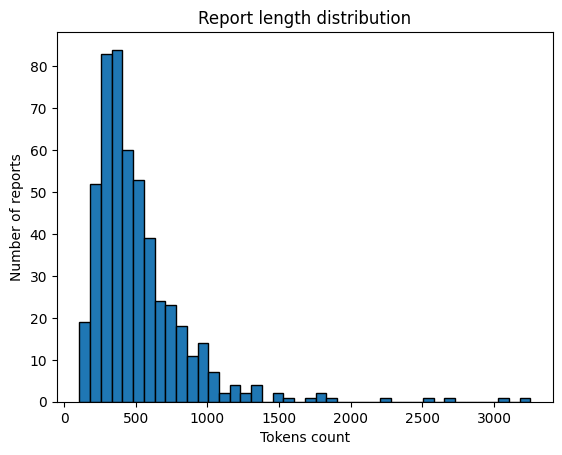

In [6]:
extractor.count(measure="tokens", as_="hist")

In [7]:
from typing import Literal

# Create metadata
class Metadata(BaseModel):
    medical_issues: bool = Field(
        description="Whether the report mentions **medical** issues (e.g. eyesight, epilepsy, diabetes, etc etc) (True) or not (False); must be medical for True - e.g. blindspots are not eyesight problems.")
    medical_desc: str = Field(
        description="If `medical_issues` is True only, give around 2-4 words saying what the medical problem is.")
    elderly: bool = Field(
        description="Whether the report explicitly mentions issues directly related to the deceased's elderly status (True) or not (False)")
    age: int = Field(
        description="If given, age of the *deceased* in years")
    dvla: bool = Field(
        description="Whether the report explicitly mentions failures to notify DVLA of something, such as medical changes or similar (True) or not (False).")
    dvla_desc: str = Field(
        description="If `dvla` is True only, give a *very* brief description of what the DVLA were *not* notified about.")
    sex: str = Field(description="The sex of the deceased. You may infer sex from pronouns (e.g. 'He', 'Her', etc.) or the deceased's name, if not stated.")
    traffic_role: Literal["Pedestrian", "Driver", "Cyclist", "Motorcyclist", "E-scooter rider", "Other", "Not clearly specified"] = Field(
        description="Traffic role of the *deceased*")

In [8]:
tagged_reports = extractor.extract_features(
        feature_model=Metadata,
        allow_multiple=True, 
        force_assign=False
)

Extracting features: 100%|██████████| 511/511 [00:26<00:00, 19.52it/s]


In [9]:
tagged_reports

,url,id,date,coroner,area,receiver,investigation,circumstances,concerns,medical_issues,medical_desc,elderly,age,dvla,dvla_desc,sex,traffic_role
7,https://www.judiciary.uk/prevention-of-future-...,2025-0592,2025-11-20,R. Travers,Surrey,Toyota (GB) PLC; Toyota Motor Corporation; Toy...,I commenced an investigation into the death of...,"On the morning of 11 January 2022, Lisa Bowen ...","Concern 1 As stated above, the brakes on the D...",False,<NA>,False,<NA>,False,<NA>,Female,Driver
19,https://www.judiciary.uk/prevention-of-future-...,2025-0572,2025-11-12,A. Hodson,Birmingham and Solihull,Secretary of State for Transport; DVLA; The Ge...,On 21 April 2022 I commenced an investigation ...,Chris was a front seat passenger in a Mazda au...,1. I heard evidence in this inquest concerning...,False,<NA>,False,<NA>,False,<NA>,Male,Other
30,https://www.judiciary.uk/prevention-of-future-...,2025-0568,2025-11-06,G. Davies,Cornwall and the Isles of Scilly,Service Director for Environment Cornwall Council,"On 16 December 2024, I commenced an investigat...",Mr Vass was a Royal Navy serviceman based at R...,The concern is the absence of speed enforcemen...,True,alcohol intoxication,False,22,False,<NA>,Male,Driver
52,https://www.judiciary.uk/prevention-of-future-...,2025-0539,2025-10-24,A. Gruffydd,Other,South Wales Police Chief Constable Jeremy Vaug...,On the 13 December 2022 I commenced an investi...,The deceased was Alexander Rhys Lewis and he w...,1. There was no opportunity for the pursuing d...,False,<NA>,False,<NA>,False,<NA>,Male,Motorcyclist
71,https://www.judiciary.uk/prevention-of-future-...,2025-0523,2025-10-16,R. Cohen,Cumbria,The Secretary of State for Transport,On 17 February 2023 I commenced an investigati...,Each of these three deaths occurred when a dri...,(1) The DVLA witnesses confirmed to me that th...,False,<NA>,False,70,False,<NA>,Male,Passenger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6020,https://www.judiciary.uk/prevention-of-future-...,2013-0209,2013-08-29,T. Osborne,Gloucestershire,British Board of Agrément,The inquest into the death of Martin Leslie Br...,The inquest into the death of Martin Leslie Br...,(1) There may be a possible dispute as to the ...,False,<NA>,False,<NA>,False,<NA>,male,Driver
6029,https://www.judiciary.uk/prevention-of-future-...,2013-0189,2013-08-16,J. Gittins,North Wales (East and Central),The Association of British Insurers; DVLA; VOSA,On 24 July 2012 I commenced an investigation i...,On 22 July 2012 Sadie was a rear seat passenge...,(1) Evidence was given by [REDACTED] Advanced ...,False,<NA>,False,6,False,<NA>,Female,Passenger
6032,https://www.judiciary.uk/prevention-of-future-...,2013-0170,2013-08-13,M. Rose,Somerset,The County Surveyor; Somerset County Council,"On 13 November 2023, I commenced an investigat...",The deceased was a front seat passenger of a L...,That I have between one and two deaths per yea...,False,<NA>,False,30,False,<NA>,Male,Other
6036,https://www.judiciary.uk/prevention-of-future-...,2013-0180,2013-08-07,D. Roberts,Cumbria,"Cumbria County Council, Highways and Transport...",On 2 September 2012 I commenced an investigati...,On 2 September 2012 the deceased was riding hi...,There is no barrier or restriction at the end ...,False,<NA>,False,<NA>,False,<NA>,male,Cyclist


In [10]:
# Save to csv

tagged_reports.to_csv('../data/road_traffic.csv')